In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import re
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# -----------------------------
# 1. Basic Urdu text normalization
# -----------------------------
def clean_urdu(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'https?://\S+', ' ', text)
    text = re.sub(r'[@#]\w+', ' ', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [ ]:
# -----------------------------
# 2. Load your uploaded datasets
# -----------------------------
train_path = "/content/train.csv"
test_path = "/content/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

TEXT_COL = "text"
LABEL_COL = "label"

df_train.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)
df_test.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)

df_train[TEXT_COL] = df_train[TEXT_COL].apply(clean_urdu)
df_test[TEXT_COL] = df_test[TEXT_COL].apply(clean_urdu)

In [ ]:
# -----------------------------
# 3. Encode labels
# -----------------------------
le = LabelEncoder()
df_train["label_enc"] = le.fit_transform(df_train[LABEL_COL].astype(str))
df_test["label_enc"] = le.transform(df_test[LABEL_COL].astype(str))

num_labels = len(le.classes_)
print("Detected labels:", le.classes_)

Detected labels: ['0' '1']


In [ ]:
# -----------------------------
# 4. Convert to HuggingFace Dataset
# -----------------------------
train_ds = Dataset.from_pandas(df_train[[TEXT_COL, "label_enc"]])
test_ds = Dataset.from_pandas(df_test[[TEXT_COL, "label_enc"]])

# Rename columns safely
if TEXT_COL != "text":
    train_ds = train_ds.rename_column(TEXT_COL, "text")
    test_ds = test_ds.rename_column(TEXT_COL, "text")

train_ds = train_ds.rename_column("label_enc", "label")
test_ds = test_ds.rename_column("label_enc", "label")

ds = DatasetDict({
    "train": train_ds,
    "test": test_ds
})


In [ ]:
# -----------------------------
# 5. Load tokenizer + model
# -----------------------------
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# -----------------------------
# 6. Tokenization
# -----------------------------
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        max_length=256,
        truncation=True
    )

tokenized_ds = ds.map(tokenize_fn, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/62727 [00:00<?, ? examples/s]

Map:   0%|          | 0/15682 [00:00<?, ? examples/s]

In [ ]:
# -----------------------------
# 7. Metrics
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        "accuracy": acc,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1
    }


In [ ]:
# -----------------------------
# 8. TrainingArguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./xlmr_fnd_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    processing_class=tokenizer,   # <-- new recommended argument
    data_collator=data_collator,
    compute_metrics=compute_metrics
)



In [ ]:
# -----------------------------
# 9. Train
# -----------------------------
print("\nStarting training...")
trainer.train()

print("\nEvaluating on test set...")
metrics = trainer.evaluate()
print(metrics)


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted
1,0.181200,0.181958,0.945288,0.946632,0.945288,0.945111


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted
1,0.181200,0.181958,0.945288,0.946632,0.945288,0.945111
2,0.149800,0.167239,0.959253,0.959298,0.959253,0.959228
3,0.096600,0.178433,0.961676,0.961762,0.961676,0.961647



Evaluating on test set...


{'eval_loss': 0.17843292653560638, 'eval_accuracy': 0.9616758066573141, 'eval_precision_weighted': 0.9617620256273578, 'eval_recall_weighted': 0.9616758066573141, 'eval_f1_weighted': 0.9616470427483824, 'eval_runtime': 26.3843, 'eval_samples_per_second': 594.37, 'eval_steps_per_second': 18.61, 'epoch': 3.0}


In [ ]:
# -----------------------------
# 10. Save model + tokenizer + label mapping
# -----------------------------
save_dir = "./xlmr_fnd_model"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

import json
with open(os.path.join(save_dir, "label_mapping.json"), "w", encoding="utf-8") as f:
    json.dump({i: l for i, l in enumerate(le.classes_)}, f, indent=2, ensure_ascii=False)

print("\n✅ Training complete! Model saved at:", save_dir)



✅ Training complete! Model saved at: ./xlmr_fnd_model


In [ ]:
!zip -r xlmr_fnd_model.zip xlmr_fnd_model


  adding: xlmr_fnd_model/ (stored 0%)
  adding: xlmr_fnd_model/tokenizer_config.json (deflated 76%)
  adding: xlmr_fnd_model/training_args.bin (deflated 53%)
  adding: xlmr_fnd_model/sentencepiece.bpe.model (deflated 49%)
  adding: xlmr_fnd_model/config.json (deflated 50%)
  adding: xlmr_fnd_model/model.safetensors (deflated 27%)
  adding: xlmr_fnd_model/tokenizer.json (deflated 76%)
  adding: xlmr_fnd_model/checkpoint-375/ (stored 0%)
  adding: xlmr_fnd_model/checkpoint-375/tokenizer_config.json (deflated 76%)
  adding: xlmr_fnd_model/checkpoint-375/training_args.bin (deflated 53%)
  adding: xlmr_fnd_model/checkpoint-375/scheduler.pt (deflated 61%)
  adding: xlmr_fnd_model/checkpoint-375/trainer_state.json (deflated 66%)
  adding: xlmr_fnd_model/checkpoint-375/sentencepiece.bpe.model (deflated 49%)
  adding: xlmr_fnd_model/checkpoint-375/config.json (deflated 50%)
  adding: xlmr_fnd_model/checkpoint-375/scaler.pt (deflated 64%)
  adding: xlmr_fnd_model/checkpoint-375/model.safetensors

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


Generating confusion matrix...


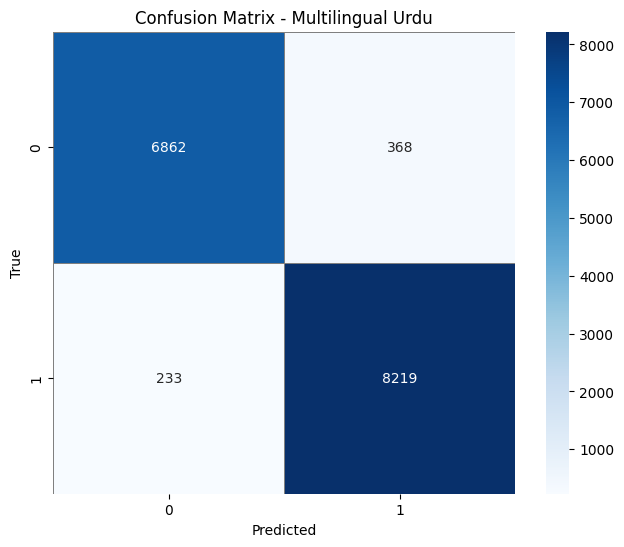


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      7230
           1       0.96      0.97      0.96      8452

    accuracy                           0.96     15682
   macro avg       0.96      0.96      0.96     15682
weighted avg       0.96      0.96      0.96     15682



In [ ]:
# -------------------------------------------------
# 13. CONFUSION MATRIX
# -------------------------------------------------
print("\nGenerating confusion matrix...")

# Get predictions on test set
predictions = trainer.predict(tokenized_ds["test"])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",           # Blue to white color map
    linewidths=0.5,
    linecolor='gray',
    square=True
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Multilingual Urdu")
plt.show()

print("\nClassification Report:\n")
print(classification_report(true_labels, preds, target_names=le.classes_))
